In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU
from sklearn import metrics


In [ ]:
# set random seed

tf.random.set_seed(1234)

In [ ]:
df = pd.read_csv("Potato Desi 2010-21.xlsx", parse_dates = ['date'], index_col=0)
df = df.interpolate(method="linear", limit_direction="both")

In [ ]:
df

,price
date,
2010-01-01,850.0
2010-01-02,900.0
2010-01-03,900.0
2010-01-04,900.0
2010-01-05,900.0
...,...
2021-05-27,600.0
2021-05-28,700.0
2021-05-29,700.0


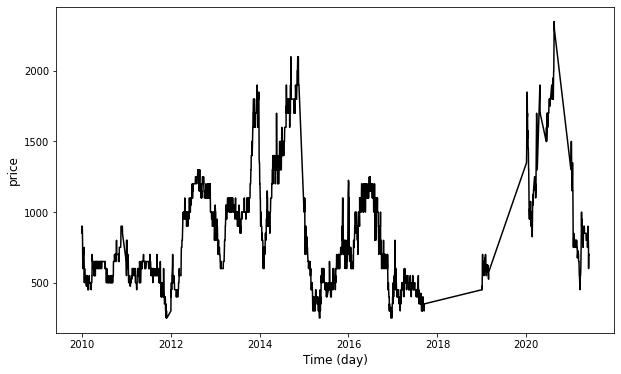

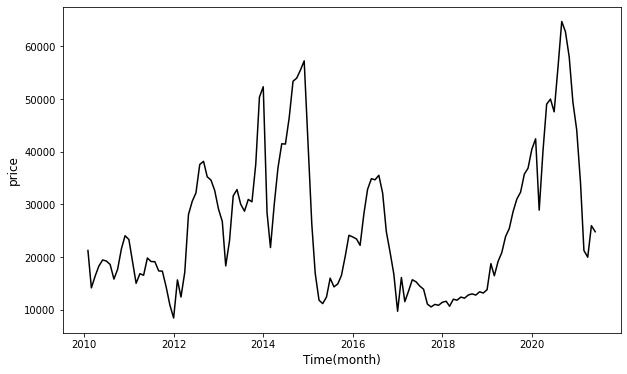

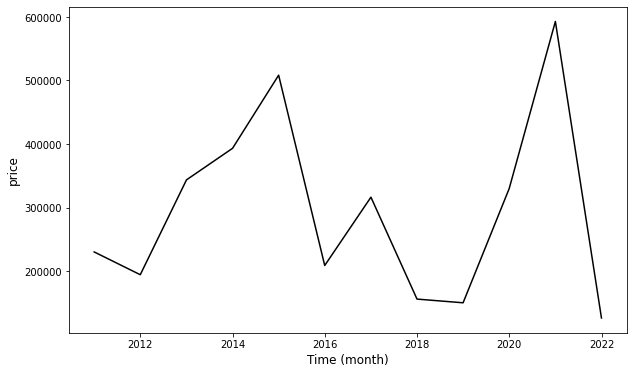

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('price', {'fontsize': 12})
dataset = df.copy()
timeseries(df.index, dataset["price"], 'Time (day)')
dataset['month'] = dataset.index.month
dataset_by_month = dataset.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month["price"], 
           'Time(month)')
dataset['year'] = dataset.index.year
dataset_by_year = dataset.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year["price"], 
           'Time (month)')

In [ ]:
# Split train data and test data
train_size = int(len(df)*0.8)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]


In [ ]:
train_data.shape

(3335, 1)

In [ ]:
data = df.iloc[:]

In [ ]:
data.shape

(4169, 1)

In [ ]:
# min max scaler

scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)
data_scaled = scaler.transform(data)

In [ ]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)

# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)
print('data.shape: ', data.shape)

X_train.shape:  (3305, 30, 1)
y_train.shape:  (3305, 1)
X_test.shape:  (804, 30, 1)
y_test.shape:  (804, 1)
data.shape:  (4169, 1)


In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 35,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)


Epoch 1/35
166/166 [==============================] - 10s 9ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 2/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0088 - val_loss: 5.7037e-04
Epoch 3/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0073 - val_loss: 1.9716e-04
Epoch 4/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0026 - val_loss: 3.3166e-04
Epoch 5/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 3.4802e-04
Epoch 6/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 7.1768e-04
Epoch 7/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0037 - val_loss: 4.5347e-04
Epoch 8/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 3.8869e-04
Epoch 9/35
166/166 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 5.3955e-04
Epoch 10/35
166/166 [==============================] - 1s 6ms/step 

In [ ]:
# inverse transform

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)
data_transform = scaler.inverse_transform(data_scaled)

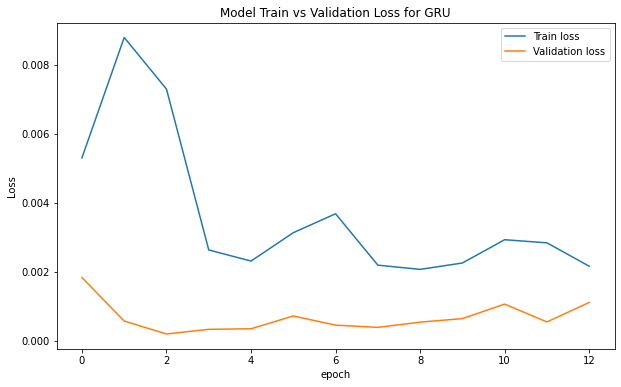

In [ ]:
# evaluate model's performance

def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')



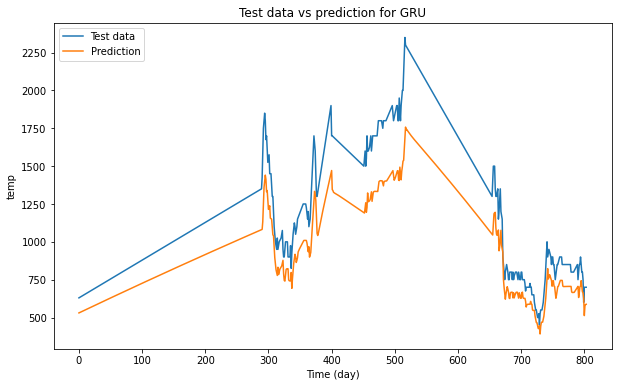

In [ ]:
# compare prediction vs test data

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('temp')
 
plot_future(prediction_gru, 'GRU', y_test)


In [ ]:
# calculate RMSE and MAE

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')


GRU:
Mean Absolute Error: 249.5132
Root Mean Square Error: 277.5489



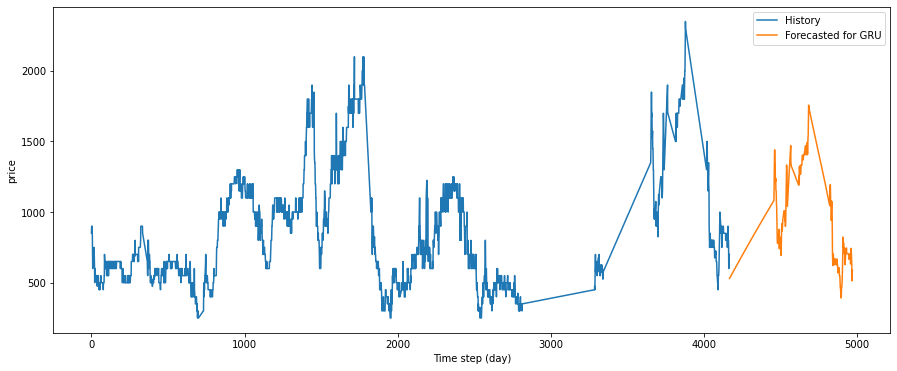

In [ ]:
# multi step forecasting

# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_test[-365:])
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru1 = prediction(model_gru)

# Plot history and future
def plot_multi_step(history, prediction1):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for GRU')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('price')
        
plot_multi_step(df, prediction_gru)


In [ ]:
prediction_gru1.shape

(365, 1)

In [ ]:
prediction_gru1

array([[1227.3508 ],
       [1224.5023 ],
       [1221.6523 ],
       [1218.8009 ],
       [1215.9481 ],
       [1213.0939 ],
       [1210.2383 ],
       [1207.3812 ],
       [1204.5227 ],
       [1201.663  ],
       [1198.8016 ],
       [1195.9388 ],
       [1193.0748 ],
       [1190.2092 ],
       [1223.2528 ],
       [1258.3351 ],
       [1195.5221 ],
       [1226.3291 ],
       [1322.8727 ],
       [1264.6248 ],
       [1266.7733 ],
       [1271.1401 ],
       [1279.4419 ],
       [1304.3647 ],
       [1330.3463 ],
       [1267.6227 ],
       [1297.7035 ],
       [1328.1381 ],
       [1331.6783 ],
       [1333.5361 ],
       [1333.4923 ],
       [1333.2709 ],
       [1332.9684 ],
       [1332.7117 ],
       [1332.5079 ],
       [1364.4061 ],
       [1397.8893 ],
       [1401.6527 ],
       [1403.8523 ],
       [1403.7239 ],
       [1403.3976 ],
       [1402.9586 ],
       [1386.7068 ],
       [1369.6007 ],
       [1399.07   ],
       [1399.5609 ],
       [1401.7764 ],
       [1401.

In [ ]:
list1 = [1,2,3,4,5,6,7,8,9,10]

In [ ]:
list1[-3:]

[8, 9, 10]

In [ ]:
prediction_gru1.tofile('predicted_gru potato.csv', sep = ',')

In [ ]:
X_test.to_csv

AttributeError: ignored